# Day 5: Hydrothermal Venture

You come across a field of hydrothermal vents on the ocean floor! These vents constantly produce large, opaque clouds, so it would be best to avoid them if possible.

They tend to form in lines; the submarine helpfully produces a list of nearby lines of vents (your puzzle input) for you to review. For example:

```
0,9 -> 5,9
8,0 -> 0,8
9,4 -> 3,4
2,2 -> 2,1
7,0 -> 7,4
6,4 -> 2,0
0,9 -> 2,9
3,4 -> 1,4
0,0 -> 8,8
5,5 -> 8,2
```

Each line of vents is given as a line segment in the format x1,y1 -> x2,y2 where x1,y1 are the coordinates of one end the line segment and x2,y2 are the coordinates of the other end. These line segments include the points at both ends. In other words:

- An entry like 1,1 -> 1,3 covers points 1,1, 1,2, and 1,3.
- An entry like 9,7 -> 7,7 covers points 9,7, 8,7, and 7,7.

For now, only consider horizontal and vertical lines: lines where either x1 = x2 or y1 = y2.

So, the horizontal and vertical lines from the above list would produce the following diagram:

```
.......1..
..1....1..
..1....1..
.......1..
.112111211
..........
..........
..........
..........
222111....
```

In this diagram, the top left corner is 0,0 and the bottom right corner is 9,9. Each position is shown as the number of lines which cover that point or . if no line covers that point. The top-left pair of 1s, for example, comes from 2,2 -> 2,1; the very bottom row is formed by the overlapping lines 0,9 -> 5,9 and 0,9 -> 2,9.

To avoid the most dangerous areas, you need to determine the number of points where at least two lines overlap. In the above example, this is anywhere in the diagram with a 2 or larger - a total of 5 points.

Consider only horizontal and vertical lines. At how many points do at least two lines overlap?

In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('../data/day_05_puzzle_1', 'r') as f:
    data = f.readlines()

In [3]:
def vent_parser(input: list) -> np.array:
    coordinates = []
    for line in input:
        tmp = line.split('->')
        coords = [ [int(xy.strip()) for xy in c.split(',')] for c in tmp]
        coordinates.append(coords)
    return np.array(coordinates)

In [4]:
coords = vent_parser(data)

In [5]:
def compare_with_raw_input(input: np.array, raw: list = None) -> list:
    reconstruction = []
    for coord in input:
        xy1 = str(coord[0][0]) + ',' + str(coord[0][1])
        xy2 = str(coord[1][0]) + ',' + str(coord[1][1])
        reconstruction.append(xy1 + ' -> ' + xy2 + '\n')
    if raw:
        return reconstruction == raw
    else:
        return reconstruction
        

sanity tests that we read the data right...

In [6]:
assert compare_with_raw_input(coords, data)

In [7]:
assert coords[-1].shape == (2,2)

extract horizontal and vertical lines

In [8]:
coords_p1 = []
for c in coords:
    if (c[0][0] == c[1][0]) or (c[0][1] == c[1][1]):
        coords_p1.append(c)
coords_p1 = np.array(coords_p1)
coords_p1[-5:]

array([[[493, 725],
        [493, 529]],

       [[390, 240],
        [702, 240]],

       [[466, 982],
        [807, 982]],

       [[477, 649],
        [477, 206]],

       [[456, 254],
        [456, 578]]])

calculate display dimensions, aka min and max of each line

In [9]:
xmax = np.concatenate((coords[:,0][:,0], coords[:,1][:,0])).max()
ymax = np.concatenate((coords[:,0][:,1], coords[:,1][:,1])).max()
xmin = np.concatenate((coords[:,0][:,0], coords[:,1][:,0])).min()
ymin = np.concatenate((coords[:,0][:,1], coords[:,1][:,1])).min()

In [10]:
print('display min resolution x-y:', xmin, ymin)
print('display max resolution x-y:', xmax, ymax)

display min resolution x-y: 10 10
display max resolution x-y: 989 989


In [11]:
t_map = {'vertical': 0,
         'horizontal': 1,
         'diagonal': 2
}
lines = []
for xy in coords:
    if xy[0][0] == xy[1][0]:
        y_sorted = sorted([xy[0][1], xy[1][1]])
        y = np.arange(start=y_sorted[0], stop=y_sorted[1] + 1, step=1)
        x = [xy[0][0]] * y.shape[0]
        t = [0] * y.shape[0]
    elif xy[0][1] == xy[1][1]:
        x_sorted = sorted([xy[0][0], xy[1][0]])
        x = np.arange(start=x_sorted[0], stop=x_sorted[1] + 1, step=1)
        y = [xy[0][1]] * x.shape[0]
        t = [1] * x.shape[0]
    else:
        x_sorted = sorted([xy[0][0], xy[1][0]])
        x = np.arange(start=x_sorted[0], stop=x_sorted[1] + 1, step=1)
        y = np.interp(x=x, xp=[xy[0][0], xy[0][1]], fp=[xy[1][0], xy[1][1]]).astype(int)
        t = [2] * x.shape[0]

    line = np.column_stack((x, y, t))
    if line.shape[0] == 0:
        raise RuntimeError("Found line with no length")
         
    lines.append(line)

In [12]:
display = np.zeros((xmax + xmin, ymax + ymin))
for line in lines:
    if line[0, 2] in (t_map['vertical'], t_map['horizontal']):
        display[line[:, 0], line[:, 1]] += 1

In [13]:
import matplotlib.pyplot as plt

In [14]:
display

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

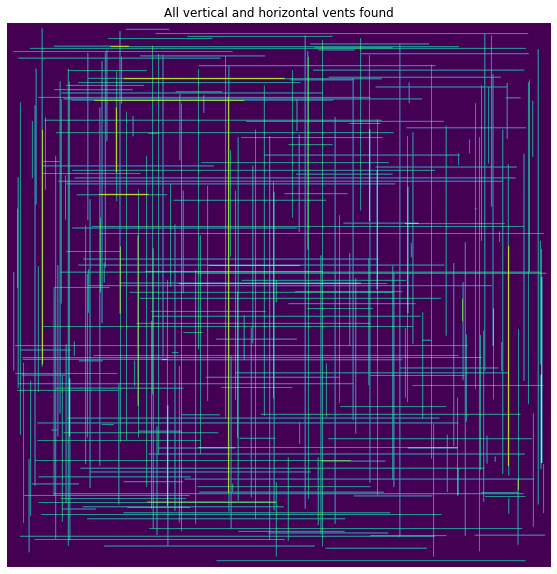

In [15]:
display[display == 0] = -100

plt.figure(figsize=[10,10])
plt.imshow(display)
plt.title("All vertical and horizontal vents found")
plt.axis(False)
plt.show()

In [16]:
dangerous_vents = (display > 1).sum()
print(f"There are {dangerous_vents} dangerous vents in your area")

There are 5306 dangerous vents in your area


# Puzzle 2

In [17]:
display = np.zeros((xmax + xmin, ymax + ymin))
for line in lines:
    display[line[:, 0], line[:, 1]] += 1

In [18]:
import matplotlib.pyplot as plt

In [19]:
display

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

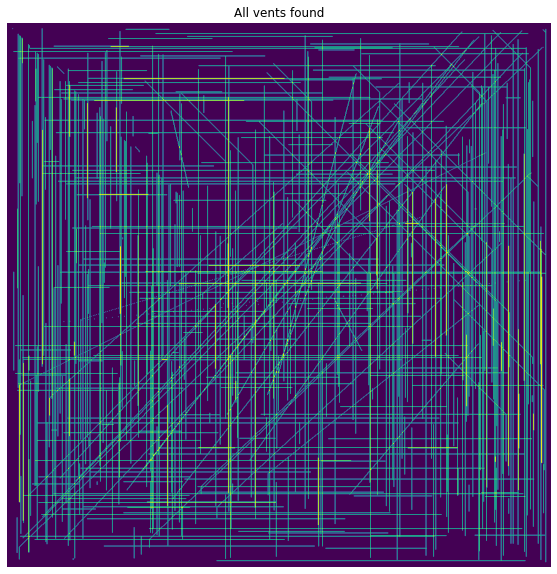

In [20]:
display[display == 0] = -100

plt.figure(figsize=[10,10])
plt.imshow(display)
plt.title("All vents found")
plt.axis(False)
plt.show()

In [21]:
dangerous_vents = (display > 1).sum()
print(f"There are {dangerous_vents} dangerous vents in your area")

There are 16950 dangerous vents in your area


this is wrong. gotta fix to 45 degrees